#  Обнаружение объектов

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
* https://pyimagesearch.com/2021/11/01/training-an-object-detector-from-scratch-in-pytorch/
* https://pyimagesearch.com/2021/08/02/pytorch-object-detection-with-pre-trained-networks/

## Задачи для совместного разбора

1\. Рассмотрите простейшую архитектуру для решения задачи object detection и процесс настройки модели.

In [ ]:
import torch as th
import torch.nn as nn

In [ ]:
imgs = th.rand(size=(16, 3, 100, 100))
bboxes_true = th.rand(size=(16, 4))
labels_true = th.randint(0, 2, size=(16, ))

In [ ]:
imgs[0].shape

torch.Size([3, 100, 100])

In [ ]:
bboxes_true[0]

tensor([0.4889, 0.8397, 0.2017, 0.8053])

In [ ]:
labels_true[0]

tensor(0)

In [ ]:
m = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
m(imgs[0]).shape

torch.Size([64, 49, 49])

In [ ]:
49*49*64

153664

In [ ]:
class Detector(nn.Module):
  def __init__(self):
    super().__init__()
    self.backbone = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.regressor = nn.Sequential(
        nn.Linear(153664, 64),
        nn.ReLU(),
        nn.Linear(64, 4)
    )

    self.classifier = nn.Sequential(
        nn.Linear(153664, 64),
        nn.ReLU(),
        nn.Linear(64, 2)
    )

  def forward(self, X):
    features = self.backbone(X).flatten(start_dim=1)
    bbox = self.regressor(features)
    labels = self.classifier(features)

    return bbox, labels

In [ ]:
model = Detector()
bboxes_pred, labels_pred = model(imgs)

In [ ]:
mse_criterion = nn.MSELoss()
ce_criterion = nn.CrossEntropyLoss()

In [ ]:
loss = (
    0.5*mse_criterion(bboxes_pred, bboxes_true) +
    0.5*ce_criterion(labels_pred, labels_true)
)

## Задачи для самостоятельного решения

In [ ]:
import torch
import torch.nn as nn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
path_to_zip_file ='/content/drive/MyDrive/animals.zip'
directory_to_extract_to = '/content/animals/'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

<p class="task" id="1"></p>

# 1\. Напишите функцию `parse_xml`, которая читает xml-файл с разметкой изображения из архива `animals.zip` и возвращает словарь, содержащий три ключа:
```
{
        "raw": # словарь с ключами xmin, ymin, xmax, ymax
        "scaled": # словарь с ключами xmin, ymin, xmax, ymax
        "obj_name": # строка
}
```
В этом словаре `row` - абсолютные значения координат вершин bounding box, а `scaled` - относительные (нормированные на ширину и высоту изображения). Примените функцию к файлу `cat.0.xml` и выведите результат на экран.


- [ ] Проверено на семинаре

In [ ]:
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET


def parse_xml(xml_file):
  with open(xml_file, 'r') as f:
    data = f.read()

  Bs_data = BeautifulSoup(data, "xml")
  # b_raw = Bs_data.find_all('bndbox')
  return Bs_data

parse_xml('/content/animals/Asirra: cat vs dogs/cat.0.xml')

<?xml version="1.0" encoding="utf-8"?>
<annotation>
<folder>test_images</folder>
<filename>cat.0.jpg</filename>
<path>/home/alvaro/Área de Trabalho/models/research/object_detection/test_images/cat.0.jpg</path>
<source>
<database>Unknown</database>
</source>
<size>
<width>500</width>
<height>374</height>
<depth>3</depth>
</size>
<segmented>0</segmented>
<object>
<name>cat</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<difficult>0</difficult>
<bndbox>
<xmin>126</xmin>
<ymin>83</ymin>
<xmax>354</xmax>
<ymax>243</ymax>
</bndbox>
</object>
</annotation>

In [ ]:
import xml.etree.ElementTree as ET

def parse_xml(xml_file):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    # object name
    obj = root.find("object")
    obj_name = obj.find("name").text

    # bboxes
    bndbox = obj.find("bndbox")
    xmin = float(bndbox.find("xmin").text)
    ymin = float(bndbox.find("ymin").text)
    xmax = float(bndbox.find("xmax").text)
    ymax = float(bndbox.find("ymax").text)

    # iamge size
    size = root.find("size")
    width = int(size.find("width").text)
    height = int(size.find("height").text)

    # scaled coordinates
    scaled_xmin = xmin / width
    scaled_ymin = ymin / height
    scaled_xmax = xmax / width
    scaled_ymax = ymax / height

    # dict
    result = {
        "raw": {'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax},
        "scaled": {'xmin': scaled_xmin, 'ymin': scaled_ymin, 'xmax': scaled_xmax, 'ymax': scaled_ymax},
        "obj_name": obj_name,
    }

    return result

xml_file = '/content/animals/Asirra: cat vs dogs/cat.0.xml'
output = parse_xml(xml_file)
output

{'raw': {'xmin': 126.0, 'ymin': 83.0, 'xmax': 354.0, 'ymax': 243.0},
 'scaled': {'xmin': 0.252,
  'ymin': 0.22192513368983957,
  'xmax': 0.708,
  'ymax': 0.6497326203208557},
 'obj_name': 'cat'}

<p class="task" id="2"></p>

# 2\. Опишите датасет `AnimalDetectionDataset` на основе архива `animals.zip`. Реализуйте `__getitem__` таким образом, чтобы он возвращал три элемента: тензор с изображением, словарь с координатами bounding box и метку объекта. Предусмотрите возможность передавать извне при создании датасета набор преобразований для изображений, преобразование для метки объекта (для кодирования) и флаг, показывающий, нужно ли возвращать исходные или нормированные координаты bounding box.

- [ ] Проверено на семинаре

In [ ]:
import os
from torch.utils.data import Dataset
from PIL import Image

class AnimalDetectionDataset(Dataset):
    def __init__(self, root, transforms=None, target_transform=None, return_scaled=True):

        self.root = root
        self.transforms = transforms
        self.target_transform = target_transform
        self.return_scaled = return_scaled

        self.image_files = [
            f for f in os.listdir(root) if f.endswith(".jpg")
        ]
        self.annotation_files = [
            os.path.splitext(f)[0] + ".xml" for f in self.image_files
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root, self.image_files[idx])
        annotation_path = os.path.join(self.root, self.annotation_files[idx])

        image = Image.open(image_path).convert("RGB")

        parsed_data = parse_xml(annotation_path)
        bbox_raw = parsed_data["raw"]
        bbox_scaled = parsed_data["scaled"]
        label = parsed_data["obj_name"]

        bbox = bbox_scaled if self.return_scaled else bbox_raw

        if self.transforms:
            image = self.transforms(image)

        if self.target_transform:
            label = self.target_transform(label)

        return image, bbox, label



<p class="task" id="3"></p>

# 3\. Создайте объект класса `AnimalDetectionDataset` без применения преобразований и со значением `return_scaled=False`. Напишите функцию `show_image_with_bounding_box` для визуализации изображения с добавлением на него bounding box и подписи объекта. Продемонстрируйте работу функцию на изображении собаки и кошки.

- [ ] Проверено на семинаре

In [ ]:
dataset = AnimalDetectionDataset(root='/content/animals/Asirra: cat vs dogs',
                                 return_scaled=False,
)

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=486x499>,
 {'xmin': 4.102934896945953,
  'ymin': 5.64342787861824,
  'xmax': 477.2010133266449,
  'ymax': 492.7649151086807},
 'dog')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import patches


def show_image_with_bounding_box(image, bbox, label):

    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])

    plt.imshow(image)

    xmin, ymin, xmax, ymax = bbox.values()
    w = xmax - xmin
    h = ymax - ymin

    box = patches.Rectangle(
            (xmin, ymin), w, h, edgecolor="red", facecolor="none"
    )

    ax.add_patch(box)

    if label is not None:
          rx, ry = box.get_xy()
          cx = rx + box.get_width()/2.0
          cy = ry + box.get_height()/8.0
          l = ax.annotate(
            label,
            (cx, cy),
            fontsize=8,
            fontweight="bold",
            color="white",
            ha='center',
            va='center'
          )
          l.set_bbox(
            dict(facecolor='red', alpha=0.5, edgecolor='red')
          )

In [ ]:
dogs = []
cats = []

for i in range(1100):
  if dataset[i][2] == 'dog':
    dogs.append(i)
  else:
    cats.append(i)

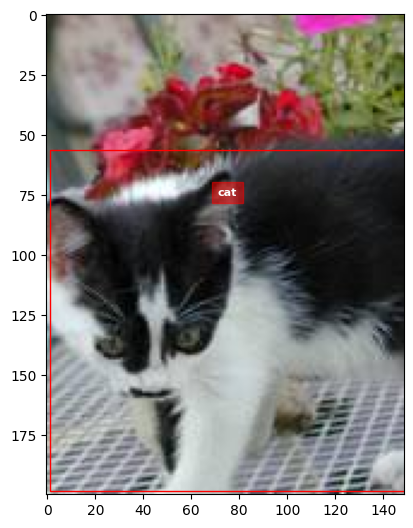

In [ ]:
image, bbox, label = dataset[3]
show_image_with_bounding_box(image, bbox, label)

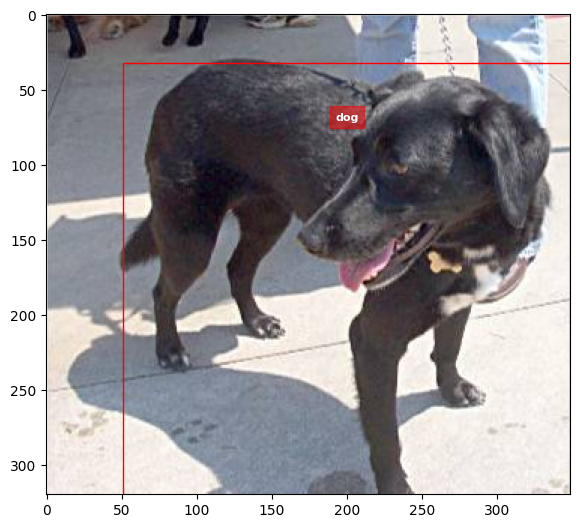

In [ ]:
image, bbox, label = dataset[1049]
show_image_with_bounding_box(image, bbox, label)

<p class="task" id="4"></p>

# 4\. Напишите модель для решения задачи выделения объектов. Реализуйте двухголовую сеть, одна голова которой предсказывает метку объекта (задача классификации), а вторая голова предсказывает 4 координаты вершин bounding box (задача регрессии). В качестве backbone используйте модель resnet50 из пакета `torchvision`.

- [ ] Проверено на семинаре

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet50


class ObjectDetectionModel(nn.Module):
    def __init__(self, num_classes, backbone=resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)):
        super().__init__()

        # Backbone
        self.backbone = nn.Sequential(*list(backbone.children())[:-2])  # Remove classification head
        self.num_classes = num_classes
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Regression head
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 512), # resnet's fc's in_features = 2048
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 4)  # Predict [xmin, ymin, xmax, ymax]
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, self.num_classes)
        )


    def forward(self, x):

        features = self.backbone(x)
        pooled_features = self.pool(features)  # Shape: [batch_size, 2048, 1, 1]

        class_logits = self.classifier(pooled_features)  # Classification head
        bbox_preds = self.regressor(pooled_features)  # Regression head
        return class_logits, bbox_preds


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s]


In [ ]:
models.resnet50()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
num_classes = 2
model = ObjectDetectionModel(num_classes=num_classes)

In [ ]:
model(image)

(tensor([[ 0.2070, -0.0928],
         [ 0.2905, -0.0197],
         [ 0.2697, -0.0280]], grad_fn=<AddmmBackward0>),
 tensor([[-0.0863,  0.0240,  0.1345, -0.0144],
         [-0.0902,  0.0304,  0.1408, -0.0352],
         [-0.0594, -0.0116,  0.1569, -0.0890]], grad_fn=<AddmmBackward0>))

<p class="task" id="5"></p>

# 5\. Разбейте набор данных на обучающее и валидационное множество. Обучите модель, описанную в задаче 4. При создании датасета не забудьте указать преобразования, соответствующие модели ResNet.

Используйте сумму MSELoss (для расчета ошибки на задаче регрессии) и CrossEntropyLoss (для расчета ошибки на задачи классификации) для настройки весов модели. Для ускорения процесса обучения слои backbone можно заморозить. Во время обучения выводите на экран значения функции потерь на обучающем и валидационном множестве. Используя обученную модель, получите предсказания для изображения кошки и собаки и отрисуйте их. Выполните процедуру, обратную нормализации, чтобы корректно отобразить фотографии.

- [ ] Проверено на семинаре

In [ ]:
import os
import random
from sklearn.model_selection import train_test_split

# Path to dataset
dataset_path = "animals/Asirra: cat vs dogs"

# Get all image-annotation pairs
all_files = [f for f in os.listdir(dataset_path) if f.endswith(".jpg")]
all_labels = [f.replace(".jpg", ".xml") for f in all_files]

# Train-validation split
train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

In [ ]:
import torchvision.models as models

models.ResNet50_Weights.IMAGENET1K_V1.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
from torchvision import transforms

# Image transforms
train_transforms = models.ResNet50_Weights.IMAGENET1K_V1.transforms()
val_transforms = models.ResNet50_Weights.IMAGENET1K_V1.transforms()

In [ ]:
from torch.utils.data import DataLoader

# Initialize datasets
train_dataset = AnimalDetectionDataset(dataset_path, train_transforms, return_scaled=False)
val_dataset = AnimalDetectionDataset(dataset_path, val_transforms, return_scaled=False)

batch_size = 16
num_workers = 2

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle for training
    num_workers=num_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,  # No shuffle for validation
    num_workers=num_workers
)

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs, device, classification_loss_fn, regression_loss_fn, optimizer):

    model.to(device)
    model.train()

    # Freeze backbone layers
    for param in model.backbone.parameters():
        param.requires_grad = False

    for epoch in range(num_epochs):
        # Initialize epoch loss accumulators
        train_classification_loss = 0.0
        train_regression_loss = 0.0
        val_classification_loss = 0.0
        val_regression_loss = 0.0

        # Training loop
        model.train()
        for images, bboxes, labels in train_loader:
            # Convert all tensors to the appropriate device
            images = images.to(device, dtype=torch.float32)
            bboxes = torch.stack([
                bboxes['xmin'],
                bboxes['ymin'],
                bboxes['xmax'],
                bboxes['ymax']
            ], dim=1).to(device, dtype=torch.float32)

            label_mapping = {'cat': 0, 'dog': 1}
            labels = torch.tensor([label_mapping[label] for label in labels], device=device, dtype=torch.long)

            # Forward pass
            class_logits, bbox_preds = model(images)

            # Compute losses
            classification_loss = classification_loss_fn(class_logits, labels)
            regression_loss = regression_loss_fn(bbox_preds, bboxes)

            # Total loss
            total_loss = classification_loss + regression_loss

            # Backward pass and optimization
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # Track training losses
            train_classification_loss += classification_loss.item()
            train_regression_loss += regression_loss.item()

        # Validation loop
        model.eval()
        with torch.no_grad():
            for images, bboxes, labels in val_loader:
                # Convert all tensors to the appropriate device
                images = images.to(device, dtype=torch.float32)
                bboxes = torch.stack([
                    bboxes['xmin'],
                    bboxes['ymin'],
                    bboxes['xmax'],
                    bboxes['ymax']
                ], dim=1).to(device, dtype=torch.float32)

                labels = torch.tensor([label_mapping[label] for label in labels], device=device, dtype=torch.long)

                # Forward pass
                class_logits, bbox_preds = model(images)

                # Compute losses
                classification_loss = classification_loss_fn(class_logits, labels)
                regression_loss = regression_loss_fn(bbox_preds, bboxes)

                # Track validation losses
                val_classification_loss += classification_loss.item()
                val_regression_loss += regression_loss.item()

        # Calculate average losses for the epoch
        train_classification_loss /= len(train_loader)
        train_regression_loss /= len(train_loader)
        val_classification_loss /= len(val_loader)
        val_regression_loss /= len(val_loader)

        # Print epoch summary
        print(f"Epoch {epoch + 1}/{num_epochs}:")
        print(f"  Train Classification Loss: {train_classification_loss:.4f}")
        print(f"  Train Regression Loss: {train_regression_loss:.4f}")
        print(f"  Val Classification Loss: {val_classification_loss:.4f}")
        print(f"  Val Regression Loss: {val_regression_loss:.4f}")


In [ ]:
num_classes = 2
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ObjectDetectionModel(num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
classification_loss_fn = nn.CrossEntropyLoss()
regression_loss_fn = nn.MSELoss()

train_model(model,
            train_loader,
            val_loader,
            num_epochs,
            device,
            classification_loss_fn,
            regression_loss_fn,
            optimizer)


Epoch 1/100:
  Train Classification Loss: 0.3016
  Train Regression Loss: 18404.8704
  Val Classification Loss: 0.0783
  Val Regression Loss: 6252.3763
Epoch 2/100:
  Train Classification Loss: 0.1873
  Train Regression Loss: 6078.1925
  Val Classification Loss: 0.1150
  Val Regression Loss: 6176.8055
Epoch 3/100:
  Train Classification Loss: 0.1291
  Train Regression Loss: 5383.8247
  Val Classification Loss: 0.0413
  Val Regression Loss: 5159.5205
Epoch 4/100:
  Train Classification Loss: 0.1069
  Train Regression Loss: 4777.0302
  Val Classification Loss: 0.0463
  Val Regression Loss: 4530.7827
Epoch 5/100:
  Train Classification Loss: 0.1038
  Train Regression Loss: 4443.2378
  Val Classification Loss: 0.0422
  Val Regression Loss: 4077.3727
Epoch 6/100:
  Train Classification Loss: 0.1094
  Train Regression Loss: 4521.0765
  Val Classification Loss: 0.0319
  Val Regression Loss: 3955.6374
Epoch 7/100:
  Train Classification Loss: 0.1215
  Train Regression Loss: 4129.4357
  Val Cla

In [ ]:
import torch
from torchvision.transforms import functional as F

def reverse_normalize(image, mean, std):
    """Reverse normalization to display the image correctly."""
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return (image * std + mean).clamp(0, 1)

mean = [0.485, 0.456, 0.406]  # Adjust to your training values
std = [0.229, 0.224, 0.225]   # Adjust to your training values

def predict_and_visualize(model, image_tensor, mean, std, device):
    """Predict bounding boxes and labels and visualize them."""
    model.eval()
    with torch.no_grad():
        # Move image to device
        image_tensor = image_tensor.to(device).unsqueeze(0)  # Add batch dimension

        # Get predictions
        class_logits, bbox_preds = model(image_tensor)
        class_probs = torch.softmax(class_logits[0], dim=0)
        predicted_class = class_probs.argmax().item()
        predicted_bbox = bbox_preds[0].cpu().numpy()

        # Reverse normalization for visualization
        image = reverse_normalize(image_tensor[0].cpu(), mean, std).permute(1, 2, 0).numpy()

        # Label mapping (adjust to your class indices)
        label_mapping = {0: "cat", 1: "dog"}
        label = label_mapping.get(predicted_class, "unknown")

        # Visualize image with bounding box
        bbox = {
            "xmin": predicted_bbox[0],
            "ymin": predicted_bbox[1],
            "xmax": predicted_bbox[2],
            "ymax": predicted_bbox[3],
        }
        show_image_with_bounding_box(image, bbox, label)

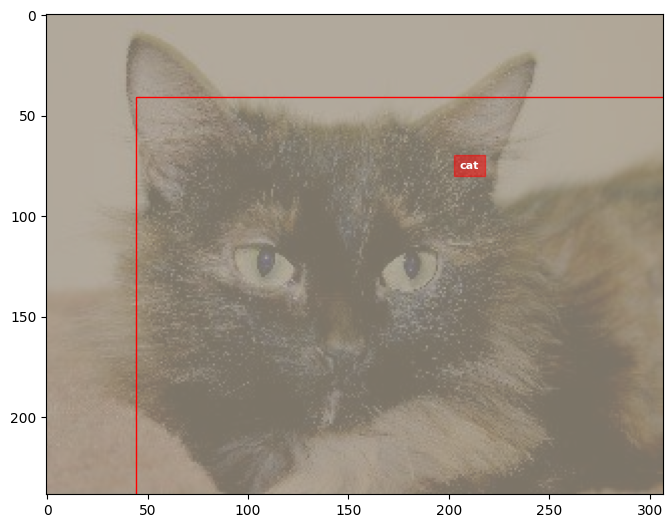

In [ ]:
image_tensor = F.to_tensor(dataset[12][0])  # Convert PIL image to tensor
predict_and_visualize(model, image_tensor, mean, std, device)

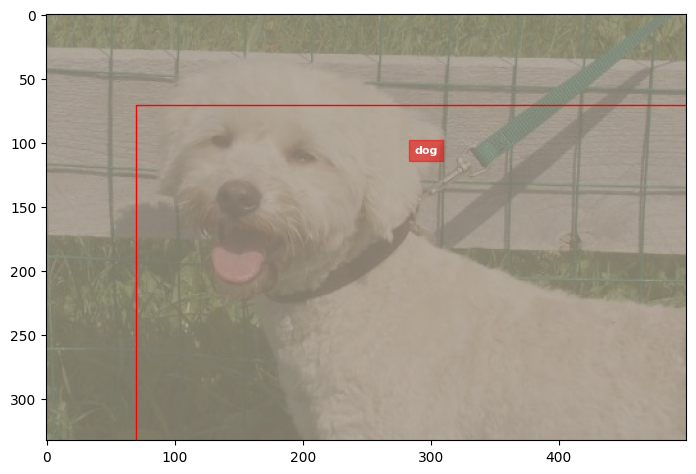

In [ ]:
image_tensor = F.to_tensor(dataset[339][0])  # Convert PIL image to tensor
predict_and_visualize(model, image_tensor, mean, std, device)

<p class="task" id="6"></p>

# 6\. Найдите в сети несколько изображений котов и собак. Используя любой инструмент для разметки (например, [CVAT](https://www.cvat.ai/)), выделите котов и собак на изображениях. Вставьте скриншот экспортированного файла с разметкой. Используя полученные изображения, визуализируйте разметку и bounding boxes, полученные при помощи модели.

- [ ] Проверено на семинаре